In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq espiownage fastai wwf # upgrade on colab

# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings.

> NOTE: IceVision will supply bounding boxes for cropping never-before-seen images.  That seems to work ok.  Putting this all together into one workflow is... the next thing. ;-) 

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade

And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

In [ ]:
path = Path('/home/shawley/datasets/espiownage-cleaner/crops')

In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total images")
ind = 1
fnames[ind]

4962 total images


Path('/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01083_156_232_247_339_1.8.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

1.8


In [ ]:
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(300),
                   batch_tfms=[*aug_transforms(size=300), Normalize.from_stats(*imagenet_stats)])

In [ ]:
#dls = ImageDataLoaders.from_path_func(path, fnames, label_func, bs=16, 
#        item_tfms=Resize(300),
#        batch_tfms=[*aug_transforms(size=300, max_warp=0), Normalize.from_stats(*imagenet_stats)])
dls = croppedrings.dataloaders(path, bs=16)

/home/shawley/envs/espi/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


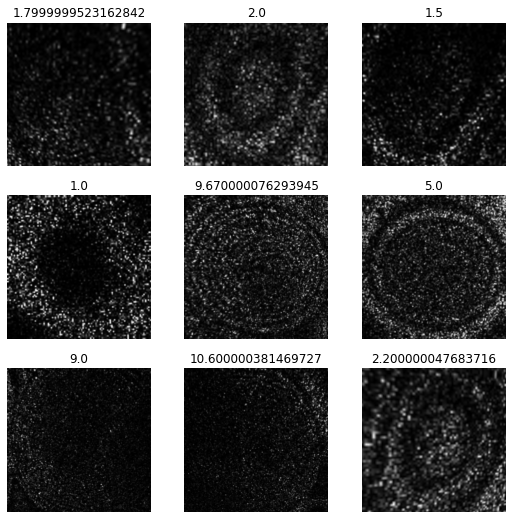

In [ ]:
dls.show_batch(max_n=9)

## Train model

In [ ]:
opt = ranger

In [ ]:
#learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

learn = cnn_learner(dls, resnet34, n_out=1, y_range=(-0.1,11.1), loss_func=MSELossFlat(), opt_func=opt)

/home/shawley/envs/espi/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0063095735386013985)

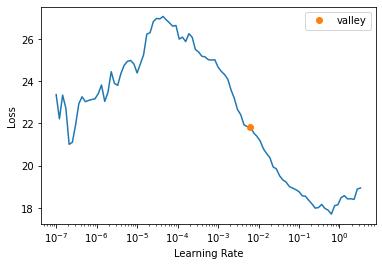

In [ ]:
learn.lr_find()

In [ ]:
lr = 4e-3
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,10.283218,9.664431,00:22
1,6.666519,3.650344,00:22
2,4.233121,3.217432,00:22
3,3.518722,2.571600,00:23
4,3.235447,2.478150,00:23


In [ ]:
learn.save('crop-rings-stage-1')

Path('models/crop-rings-stage-1.pth')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,time
0,3.592264,2.563165,00:29
1,3.501280,2.089404,00:30
2,3.200284,2.117960,00:30
3,3.014075,3.280049,00:30
4,2.714339,3.010489,00:30
5,2.675967,2.091208,00:30
6,2.497148,2.197056,00:30
7,2.327066,1.919732,00:30
8,2.186359,2.345780,00:30
9,2.046180,1.832901,00:30


In [ ]:
learn.save('stage-2')

Path('models/stage-2.pth')

## Interpretation

In [ ]:
learn.load('stage-2');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
len(preds)

992

In [ ]:
preds[0]

tensor([5.2751])

In [ ]:
dls.valid.dataset[0]

(PILImage mode=RGB size=127x127, tensor(5.7000))

In [ ]:
dls.valid.items[0]

Path('/home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01707_228_129_355_256_5.7.png')

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy()]
    results.append(line_list)

In [ ]:
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss'])
res_df.head()

,filename,target,prediction,loss
0,06240907_proc_01707_228_129_355_256_5.7,5.70,5.28,0.18054694
1,06241902_proc_01696_123_95_274_204_2.75,2.75,3.95,1.4386151
2,06240907_proc_00523_224_0_287_95_1.2,1.20,1.19,0.0001034625
3,06240907_proc_00523_282_16_341_105_1.4,1.40,2.12,0.5230406
4,06240907_proc_00428_230_123_355_242_3.0,3.00,2.91,0.0075100223


We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df

,filename,target,prediction,loss
266,06241902_proc_00510_0_45_88_236_1.0,1.00,10.19,84.45397
536,06240907_proc_01001_0_115_187_322_2.4,2.40,9.52,50.643303
232,06240907_proc_01197_0_105_185_338_3.33,3.33,10.14,46.41338
353,06241902_proc_00986_136_73_293_214_2.0,2.00,8.42,41.23445
354,06241902_proc_01468_0_58_81_211_3.75,3.75,10.17,41.174534
...,...,...,...,...
543,06241902_proc_01130_167_261_252_344_2.25,2.25,2.25,1.7022503e-05
49,06240907_proc_01489_292_12_363_111_1.0,1.00,1.00,1.171921e-05
320,06240907_proc_00673_209_0_286_93_2.7,2.70,2.70,1.0617606e-05
327,06240907_proc_00974_209_115_372_262_7.0,7.00,7.00,4.7113426e-06


So then we'll output this to a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv('ring_count_top_losses.csv', index=False)